## Changes in Precipitation and Discharge Trends in the Ammonnoosuc River Watershed, New Hampshire
Ryan Omslaer

Introduction



Research Question:

Is there an increase in 24 hour large precipitation events on the Ammonoosuc River watershed? And do these events also lead to an associated discharge increase after a lag time? My specific focuses are whether high precipitation events are increasing and identifying the lag time associated with higher discharges/floods.

Study Site:

My study site will be the Ammonoosuc River watershed in western NH. The outlet of my watershed will be defined as the USGS 01137500 gauging station, located at Bethlehem Junction, NH.

Datasets:

Datasets I will be using are the USGS Ammonoosuc River at Bethlehem Junction daily discharge records, daily precipitation records from rain gauge USC00274329 located in Jefferson NH, and a gridded precipitation reanalysis by the NOAA Physical Sciences Laboratory. The gridded reanalysis will be centered on the rain gauge location in Jefferson, NH via lat and long.

Raw Data and Plotting Code:

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import os
from pathlib import Path
from matplotlib.ticker import MaxNLocator, FuncFormatter
#import of libraries

In [15]:
qfile = 'discharge.txt'
grid_path = Path('Grid')
precip_files = ['4146341.csv', '4151138.csv', '4151152.csv']
#all input files needed

In [16]:
lat = 44.43 #latitude of Jefferson, NH
lon = 288.51 #longtitude in 0-360 format
files = sorted(glob.glob(os.path.join(grid_path, "precip.V1.0.*.nc"))) 
dfs = []
for f in files:
    ds = xr.open_dataset(f) #opens each .nc file
    precip = ds['precip']
    series = precip.sel(lat=lat, lon=lon, method='nearest') #extracts data from cell closest to Jefferson, NH
    df = series.to_dataframe().reset_index() #converts data to df format
    dfs.append(df) #each year/file is appended to a list
    ds.close()  # free memory
grid_all = pd.concat(dfs, ignore_index=True) #concatenation of each year into single df
grid_all = grid_all.drop(columns=['lat', 'lon'])
grid_all = grid_all.rename(columns={'time': 'Date'})
grid_all['Date'] = pd.to_datetime(grid_all['Date'])
grid_all = grid_all.set_index('Date')
grid_all['Grid Precip (in)'] = grid_all['precip'] / 25.4
grid_all = grid_all.drop(columns=['precip'])
grid_all

,Grid Precip (in)
Date,
1963-01-01,0.002452
1963-01-02,0.000000
1963-01-03,0.000000
1963-01-04,0.001538
1963-01-05,0.000000
...,...
2015-12-27,0.237292
2015-12-28,0.443012
2015-12-29,0.426561


In [17]:
ammo = pd.read_csv(qfile, comment='#', sep='\s+') #inports USGS style data and removes headers
ammo = ammo.drop(columns=['agency_cd', 'site_no', '64501_00060_00003_cd'])
ammo = ammo.rename(columns={'64501_00060_00003': 'Discharge (cfs)'})
ammo = ammo.rename(columns={'datetime': 'Date'})
#dropping unnecessary columns, renaming columns for clarity
ammo = ammo[ammo['Date'].str.match(r'\d{4}-\d{2}-\d{2}')] #formatting for datetime
ammo['Date'] = pd.to_datetime(ammo['Date'])
ammo = ammo.set_index('Date')
ammo

,Discharge (cfs)
Date,
1963-10-01,59.0
1963-10-02,48.0
1963-10-03,43.0
1963-10-04,52.0
1963-10-05,58.0
...,...
2025-10-18,34.0
2025-10-19,32.7
2025-10-20,64.9


In [18]:
precip_dfs = []
for f in precip_files: #loops through all precip files
    df = pd.read_csv(f)
    df = df.rename(columns={'DATE': 'Date'})
    if 'MDPR' in df.columns: #adds MDPR totals to precip if it is present
        df['MDPR'] = df['MDPR'].fillna(0)
        df['PRCP'] = df['PRCP'] + df['MDPR']
        df = df.rename(columns={'PRCP': 'Gauge Precip (in)'})
        df = df.drop(columns=['STATION', 'NAME', 'DAPR', 'DASF', 'MDSF', 'SNOW', 'SNWD', 'MDPR'], errors='ignore') #dropping unnecessary columns
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        precip_dfs.append(df) #appends all dfs to precip_dfs
precip_all = pd.concat(precip_dfs) #puts all files under the same df
precip_all = precip_all.sort_index()
precip_all

,Gauge Precip (in)
Date,
1963-08-01,0.00
1963-08-02,0.00
1963-08-03,0.00
1963-08-04,0.50
1963-08-05,1.61
...,...
2025-10-08,1.85
2025-10-09,0.15
2025-10-10,0.00


In [19]:
starts = [df.index.min() for df in [precip_all, grid_all, ammo]]
ends   = [df.index.max() for df in [precip_all, grid_all, ammo]]
start = max(starts)
end   = min(ends)
print(f"Overlapping period: {start.date()} to {end.date()}")
#finding the beginning and end of overlapping period of records

Overlapping period: 1963-10-01 to 2015-12-31


In [20]:
if isinstance(grid_all, xr.DataArray):
    grid_all = grid_all.to_series().to_frame(name='Grid Precip (in)')
precip_trimmed = precip_all.loc[start:end]
grid_all_trimmed = grid_all.loc[start:end]
ammo_trimmed = ammo.loc[start:end]
project = pd.concat([precip_trimmed, grid_all_trimmed, ammo_trimmed], axis=1, join='inner')
project
#combining all data into one df based on overlapping period

,Gauge Precip (in),Grid Precip (in),Discharge (cfs)
Date,,,
1963-10-01,0.00,0.001739,59.0
1963-10-02,0.00,0.000000,48.0
1963-10-03,0.18,0.177602,43.0
1963-10-04,0.10,0.156414,52.0
1963-10-05,0.00,0.003456,58.0
...,...,...,...
2015-12-27,0.31,0.237292,311
2015-12-28,0.33,0.443012,343
2015-12-29,0.31,0.426561,222


Text(0.5, 1.0, 'Precipitation vs Discharge')

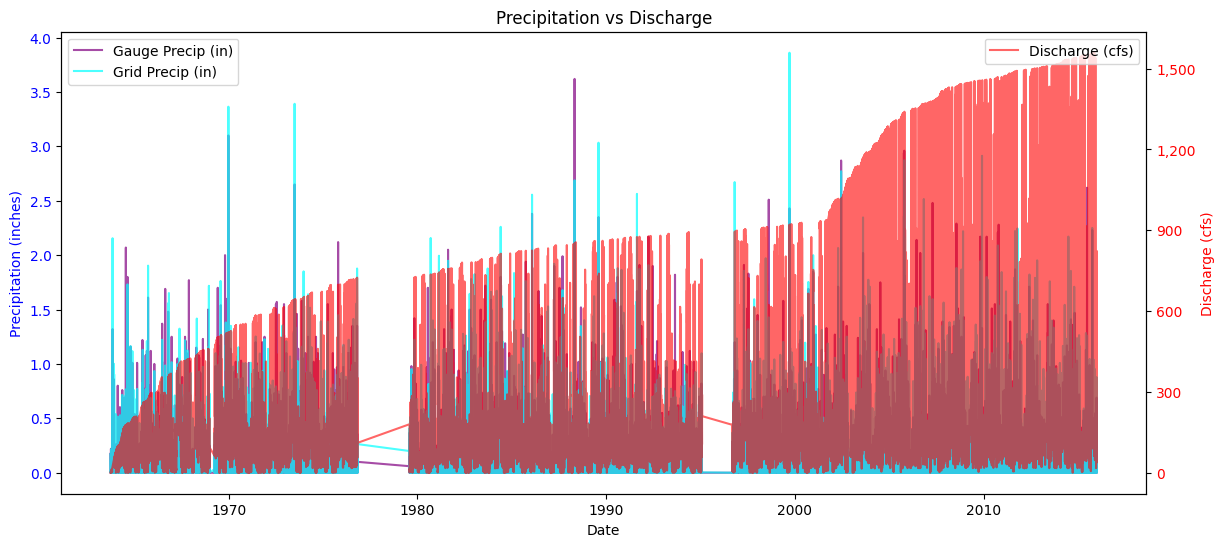

In [21]:
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(project.index, project['Gauge Precip (in)'], label='Gauge Precip (in)', color='purple', alpha=0.7)
ax1.plot(project.index, project['Grid Precip (in)'], label='Grid Precip (in)', color='cyan', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Precipitation (inches)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(project.index, project['Discharge (cfs)'], label='Discharge (cfs)', color='red', alpha=0.6)
ax2.set_ylabel('Discharge (cfs)', color='red')
ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')
ax1.set_title('Precipitation vs Discharge')
#initial plot of raw data

Planned Analyses:

Finding the associated lag time between large precipitation events and associated higher flows at the watershed outlet. Additionally running a statistical test finding what a "large" precip event is.

Recurrence Interval/Exceedance Probability calcs/plot of both gauge precipitation, grid precipitation, and discharge.

Statistical test of if the difference between the reanalysis and gauge data are statistically signifcant. Ie can we trust the reanalysis data.

Statistical analysis of if the precipitation or discharge is increasing over time.

Discussion/Conclusion:

What is the lag time between events?

Is there a difference between both types of precipitation data? There does appear to be variation looking at the raw data.

What is the result of the test analyzing increasing trends in precip/discharge over time.